In [22]:
#Rolling Mean Demand Forecasting - it calculates a rolling mean of the past 'n' hours of electricity demand to forecast future demand. It uses a rolling window approach to capture short-term demand trends.
import pandas as pd

# Load the training data
train_df = pd.read_excel("./data/train_dataframes.xlsx")

# Specify the rolling window size (e.g., 4 hours)
window_size = 4

# Create a new column to store the rolling mean forecast
train_df['Rolling_Mean_Forecast'] = train_df['DEMAND'].rolling(window=window_size).mean()

# Drop rows with missing values in the forecast column
train_df = train_df.dropna()

# You can now use train_df to evaluate the accuracy of the rolling mean forecast.
print(train_df[['datetime', 'DEMAND', 'Rolling_Mean_Forecast']])


                 datetime     DEMAND  Rolling_Mean_Forecast
3     2015-01-31 04:00:00   889.0806             915.128025
4     2015-01-31 05:00:00   910.1472             904.114375
5     2015-01-31 06:00:00   922.1737             906.191300
6     2015-01-31 07:00:00   939.9442             915.336425
7     2015-01-31 08:00:00  1077.8575             962.530650
...                   ...        ...                    ...
36715 2019-04-09 20:00:00  1397.5788            1398.827775
36716 2019-04-09 21:00:00  1350.5093            1388.684700
36717 2019-04-09 22:00:00  1308.7955            1367.451850
36718 2019-04-09 23:00:00  1232.4521            1322.333925
36719 2019-04-10 00:00:00  1155.5925            1261.837350

[36717 rows x 3 columns]


In [23]:
# Custom Feature Engineering - It performs custom feature engineering by creating new features that capture interactions between existing features.
import pandas as pd

# Load the training data
train_df = pd.read_excel("./data/train_dataframes.xlsx")

# Define a custom feature engineering function
def custom_feature_engineering(df):
    # Create a feature that represents the interaction between 'week_X-2' and 'T2M_toc'
    df['Interaction_Feature'] = df['week_X-2'] * df['T2M_toc']
    
    # Create a feature that represents the day of the week multiplied by 'week_X-3'
    df['Day_Week_X-3'] = df['dayOfWeek'] * df['week_X-3']
    
    return df

# Apply the custom feature engineering function to the training data
train_df = custom_feature_engineering(train_df)

# You can now use train_df, including the new features, for training and prediction.
print(train_df)


                 datetime   week_X-2   week_X-3   week_X-4       MA_X-4  \
0     2015-01-31 01:00:00   962.2865   906.9580   970.3450   938.004850   
1     2015-01-31 02:00:00   933.3221   863.5135   912.1755   900.284075   
2     2015-01-31 03:00:00   903.9817   848.4447   900.2688   881.704325   
3     2015-01-31 04:00:00   900.9995   839.8821   889.9538   876.458825   
4     2015-01-31 05:00:00   904.3481   847.1073   893.6865   879.190775   
...                   ...        ...        ...        ...          ...   
36715 2019-04-09 20:00:00  1362.1477  1376.6220  1335.4711  1360.112475   
36716 2019-04-09 21:00:00  1330.7467  1338.3879  1305.3631  1332.959900   
36717 2019-04-09 22:00:00  1275.5550  1281.6932  1240.1208  1279.486450   
36718 2019-04-09 23:00:00  1200.3537  1209.2950  1165.0237  1199.699525   
36719 2019-04-10 00:00:00  1141.5161  1149.9883  1099.2100  1130.238133   

       dayOfWeek  weekend  holiday  Holiday_ID  hourOfDay    T2M_toc  \
0              1        1  

In [24]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Exponential Smoothing Demand Forecasting") \
    .getOrCreate()

# Load the data into a Pandas DataFrame
excel_data_path = "./data/train_dataframes.xlsx"
train_df = pd.read_excel(excel_data_path)

# Convert the Pandas DataFrame to a Spark DataFrame
spark_df: DataFrame = spark.createDataFrame(train_df)

# Assume you have test data in another Excel sheet or file
test_excel_data_path = "./data/test_dataframes.xlsx"
test_df = pd.read_excel(test_excel_data_path)

# Convert the Pandas DataFrame to a Spark DataFrame for test data
spark_test_df: DataFrame = spark.createDataFrame(test_df)

def exponential_smoothing_forecast(series, alpha):
    forecast = [series[0]]
    for t in range(1, len(series)):
        forecast.append(alpha * series[t] + (1 - alpha) * forecast[t - 1])
    return forecast

# Define the alpha parameter (smoothing factor)
alpha = 0.2

# Check if "DEMAND" exists and its data type
if "DEMAND" not in spark_df.columns:
    raise ValueError("Column 'DEMAND' not found in the DataFrame")

# Apply exponential smoothing to DEMAND data
demand_series = spark_df.select("DEMAND").rdd.map(lambda row: row[0]).collect()
exponential_forecast = exponential_smoothing_forecast(demand_series, alpha)

# Define the test data
test_demand_series = spark_test_df.select("DEMAND").rdd.map(lambda row: row[0]).collect()

# Ensure the forecast and test data have the same length
forecast_start_index = 0
forecast_end_index = len(test_demand_series)
aligned_forecast = exponential_forecast[forecast_start_index:forecast_end_index]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_demand_series, aligned_forecast))
print(f"RMSE for Exponential Smoothing: {rmse}")


C:\Users\tjyua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:
C:\Users\tjyua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


RMSE for Exponential Smoothing: 199.11975817446654


In [25]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Exponential Smoothing Demand Forecasting") \
    .getOrCreate()

# Load the data into a Pandas DataFrame
excel_data_path = "./data/train_dataframes.xlsx"
train_df = pd.read_excel(excel_data_path)

# Convert the Pandas DataFrame to a Spark DataFrame
spark_df: DataFrame = spark.createDataFrame(train_df)

# Assume you have test data in another Excel sheet or file
test_excel_data_path = "./data/test_dataframes.xlsx"
test_df = pd.read_excel(test_excel_data_path)

# Convert the Pandas DataFrame to a Spark DataFrame for test data
spark_test_df: DataFrame = spark.createDataFrame(test_df)

def exponential_smoothing_forecast(series, alpha):
    forecast = [series[0] for t in range(1, len(series))]
    for t in range(1, len(series)):
        forecast.append(alpha * series[t] + (1 - alpha) * forecast[t - 1])
    return forecast

# Define the alpha parameter (smoothing factor)
alpha = 0.2

# Check if "DEMAND" exists and its data type
if "DEMAND" not in spark_df.columns:
    raise ValueError("Column 'DEMAND' not found in the DataFrame")

# Apply exponential smoothing to DEMAND data
demand_series = spark_df.select("DEMAND").rdd.map(lambda row: row[0]).collect()
exponential_forecast = exponential_smoothing_forecast(demand_series, alpha)

# Define the test data
test_demand_series = spark_test_df.select("DEMAND").rdd.map(lambda row: row[0]).collect()

# Ensure the forecast and test data have the same length
forecast_start_index = 0
forecast_end_index = len(test_demand_series)
aligned_forecast = exponential_forecast[forecast_start_index:forecast_end_index]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_demand_series, aligned_forecast))
print(f"RMSE for Exponential Smoothing: {rmse}")


C:\Users\tjyua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:
C:\Users\tjyua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


RMSE for Exponential Smoothing: 360.1011533061308


In [26]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\tjyua\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


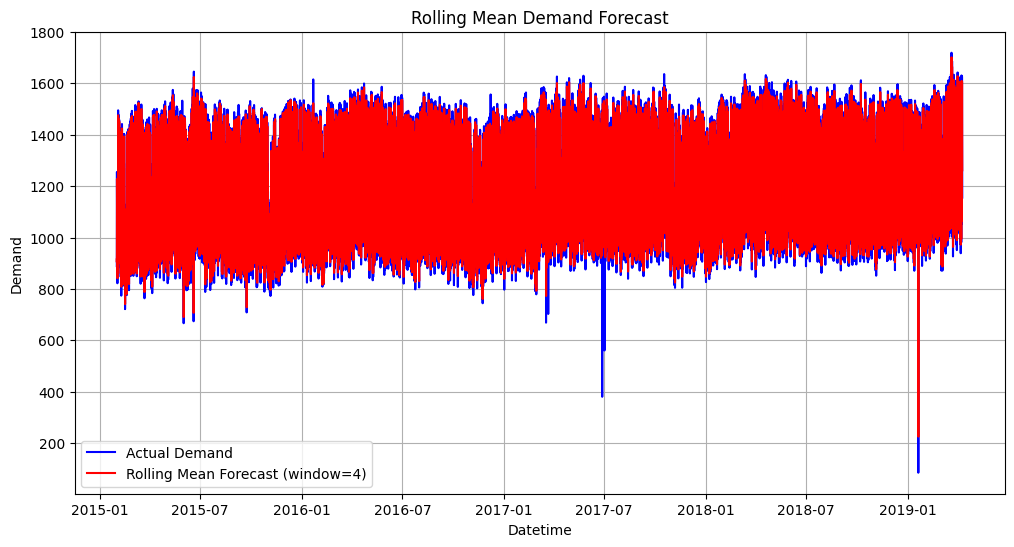

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training data
train_df = pd.read_excel("./data/train_dataframes.xlsx")

# Specify the rolling window size (e.g., 4 hours)
window_size = 4

# Create a new column to store the rolling mean forecast
train_df['Rolling_Mean_Forecast'] = train_df['DEMAND'].rolling(window=window_size).mean()

# Drop rows with missing values in the forecast column
train_df = train_df.dropna()

# Plot the actual demand and the rolling mean forecast
plt.figure(figsize=(12, 6))
plt.plot(train_df['datetime'], train_df['DEMAND'], label='Actual Demand', color='blue')
plt.plot(train_df['datetime'], train_df['Rolling_Mean_Forecast'], label=f'Rolling Mean Forecast (window={window_size})', color='red')
plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.legend()
plt.title('Rolling Mean Demand Forecast')
plt.grid()
plt.show()


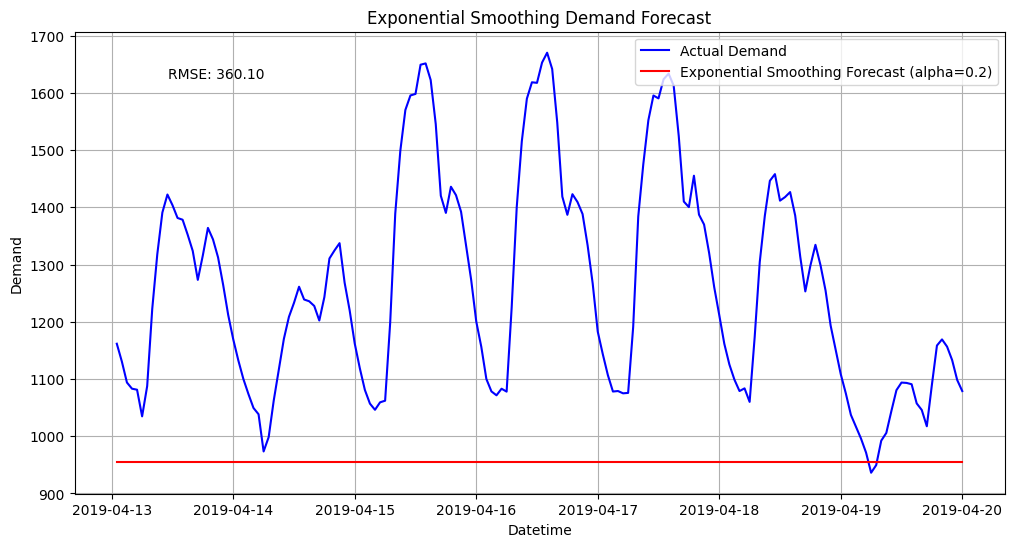

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error


# Plot the actual demand and the exponential smoothing forecast
plt.figure(figsize=(12, 6))
plt.plot(test_df['datetime'], test_demand_series, label='Actual Demand', color='blue')
plt.plot(test_df['datetime'], aligned_forecast, label=f'Exponential Smoothing Forecast (alpha={alpha})', color='red')
plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.legend()
plt.title('Exponential Smoothing Demand Forecast')
plt.grid()

# Calculate RMSE and display it on the plot
plt.text(0.1, 0.9, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes)

plt.show()
